In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneOut, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn import svm

%matplotlib inline

# Exploratory Data Analysis

First let us read the data into a pandas DataFrame.

In [2]:
data = pd.read_excel('data.xlsx')

In [3]:
print 'Number of samples: ', data.shape[0]

Number of samples:  296


It will be useful to isolate the columns which deal with scores.  We will also clean up the column label by removing the trailing '_17' in each score field.

In [4]:
score_cols = [col for col in data.columns if 'score' in col]

# Replace trailing '_17' in label
for i in range(len(score_cols)):
    data.rename(columns={score_cols[i]: score_cols[i][:-3]}, inplace=True)
    score_cols[i] = score_cols[i][:-3]

## Data Completeness

First let us visualize the frequency counts of the score labels to see how complete the data is.

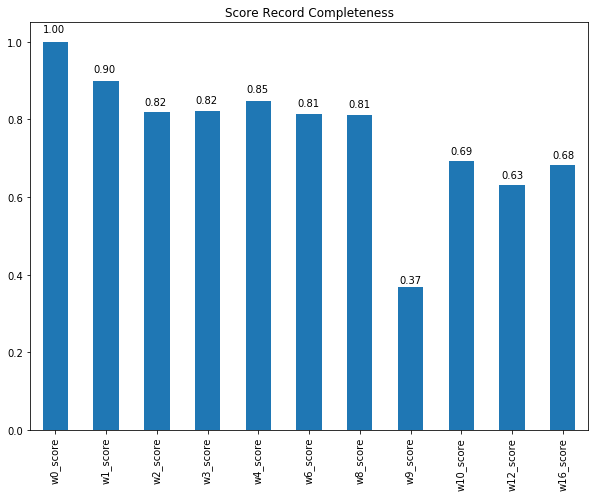

In [5]:
ax = (data[score_cols].count()/data.shape[0]).plot(kind='bar', title='Score Record Completeness', figsize=(10,7.5))
for p in ax.patches:
    ax.annotate(str(format(p.get_height(), '.2f')), (p.get_x() * 1.005, p.get_height() * 1.025))

Next let's plot the distribution of row completeness with respect to w0 to w8 scores.  For example, how many rows have data for all 7 of the trials.

In [6]:
first_trial_scores = score_cols[:7]  # w0 to w8
data['valid_scores'] = data[first_trial_scores].notnull().sum(axis=1)

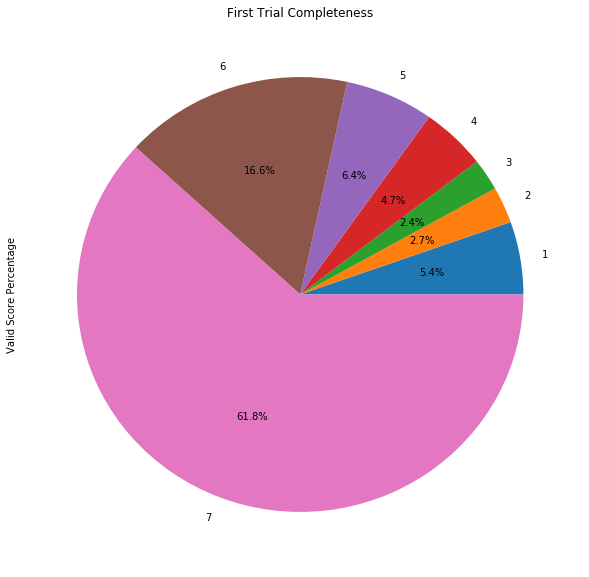

In [7]:
pd.Series(data.groupby(['valid_scores']).size()/data.shape[0], name="Valid Score Percentage").plot(kind='pie', autopct='%1.1f%%', title='First Trial Completeness', figsize=(10,10))

## Score Distributions

Next we will investigate the distribution of scores over each scoring period with respect to the entire dataset.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a140c4d90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a144e59d0>]], dtype=object)

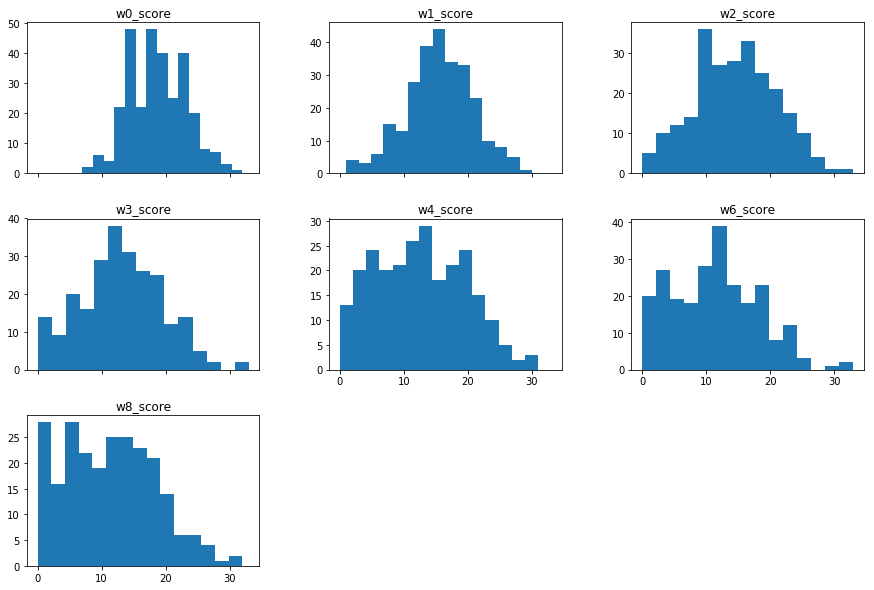

In [8]:
data.hist(column=first_trial_scores, grid=False, figsize=(15,10), bins=15, sharex=True)

The histograms above align with our prior beliefs about the domain.  As the weeks progress we see a shift in the distributions towards a right skewed shape.  This shows that many of the patients are in remission.

### Population Score Distribution

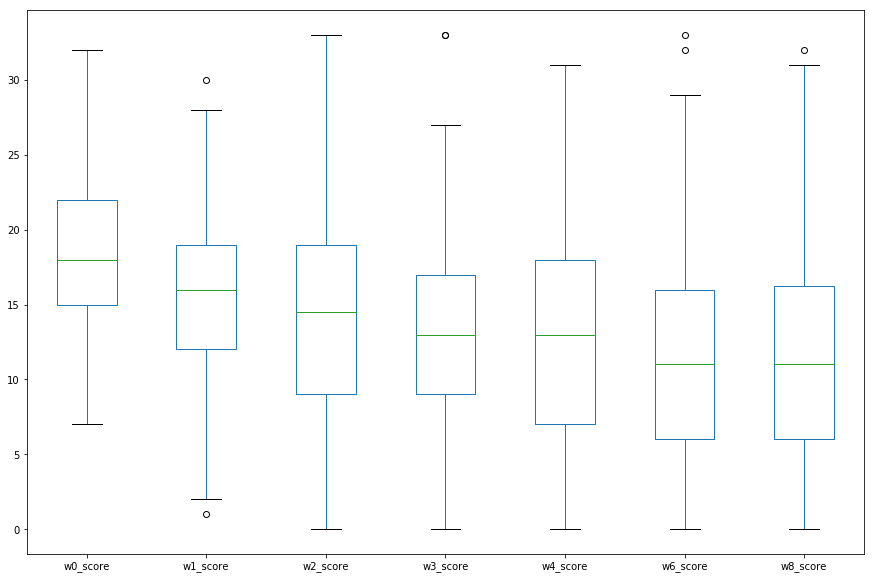

In [9]:
data.boxplot(column=first_trial_scores, grid=False, figsize=(15,10))

### Effective Treatment Score Distribution

At this point we should investigate the distributions conditioned on the class label (effective vs. ineffective).  We will use the assumption that a Hamilton score of $\leq 10$ on week 8 indicates that the treatment was effective.  Effective treatment will be labeled 1, ineffective treatment 0.

In [10]:
data['label'] = data.apply(lambda row: 1 if row.w8_score <= 10 else 0, axis=1)

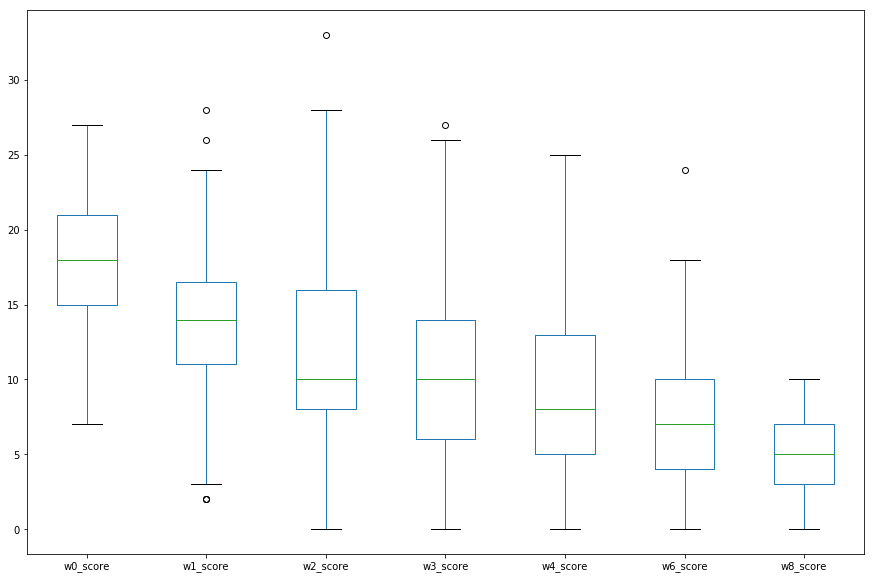

In [11]:
data.loc[data['label'] == 1].boxplot(column=first_trial_scores, grid=False, figsize=(15,10))

### Ineffective Treatment Score Distribution

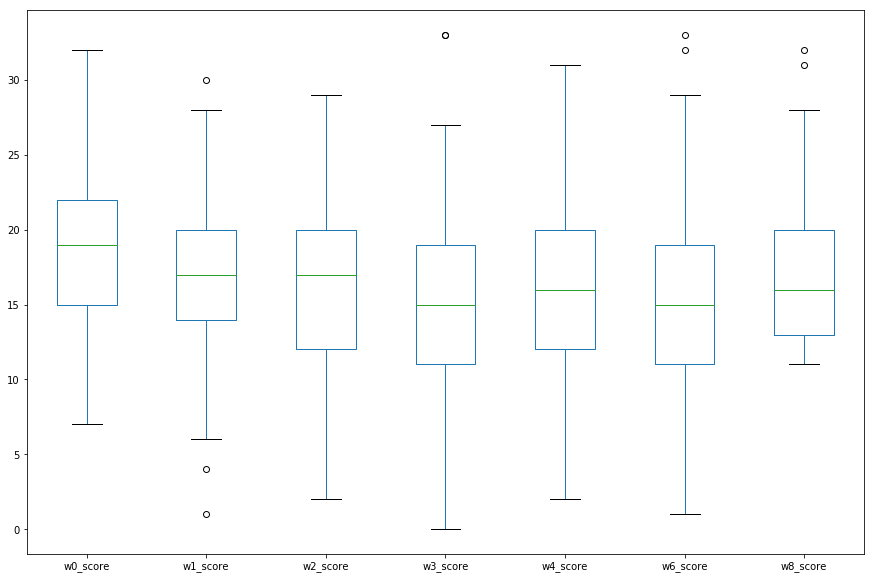

In [12]:
data.loc[data['label'] == 0].boxplot(column=first_trial_scores, grid=False, figsize=(15,10))

It seems clear that there is a difference in the distributions over time conditioned on the effectiveness of the treatment.  When the treatment is effective we see a steady decrease in the median Hamilton score.  Ineffective cases have median fluctuation which is likely attributed to noise.

### SER Score Distribution

Next let's see how the distributions vary based on the treatment type.

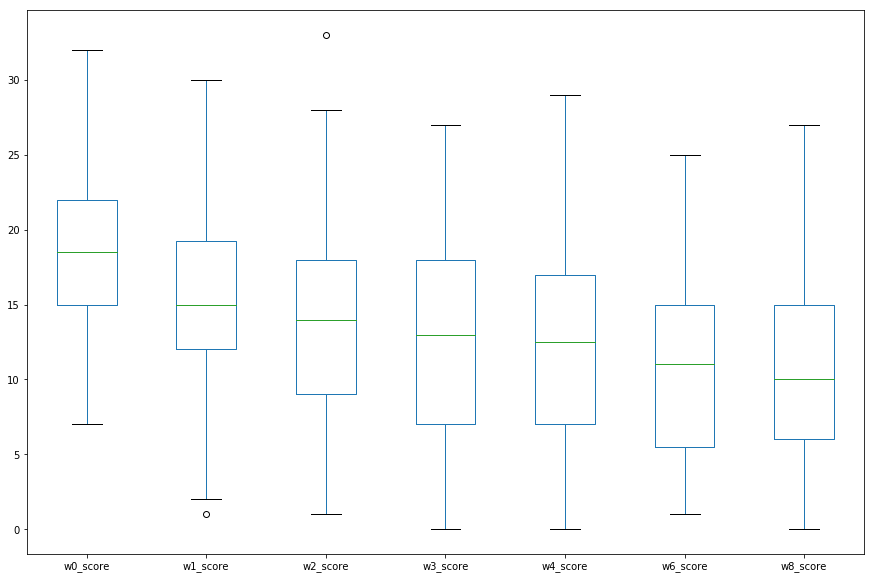

In [13]:
data.loc[data['Stage1TX'] == 'SER'].boxplot(column=first_trial_scores, grid=False, figsize=(15,10))

### PLA Score Distribution

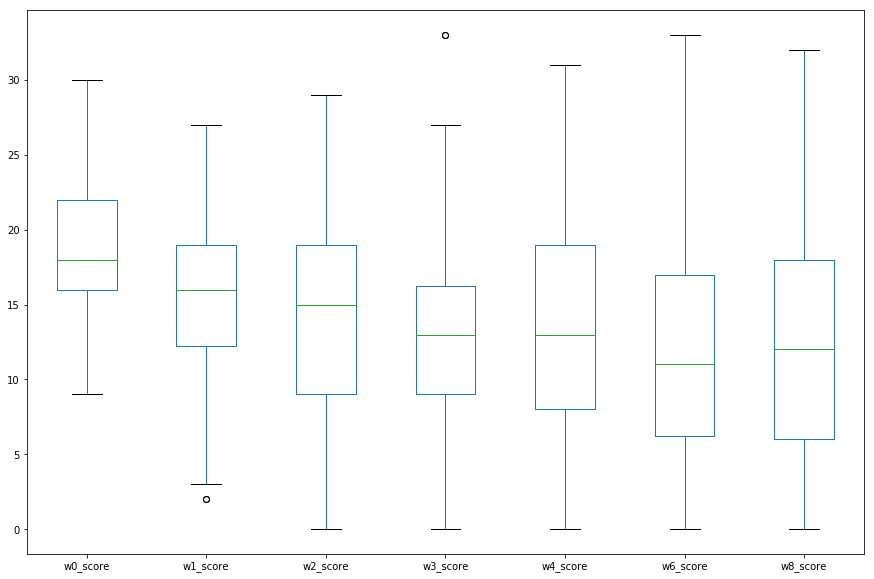

In [14]:
data.loc[data['Stage1TX'] == 'PLA'].boxplot(column=first_trial_scores, grid=False, figsize=(15,10))

The distributions with respect to treatment type do not seem to differ in a pronounced manner.

### Scorce Distributions by Effectiveness and Treatment Type

/Users/tim/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1545c150>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a158a2e90>]], dtype=object)

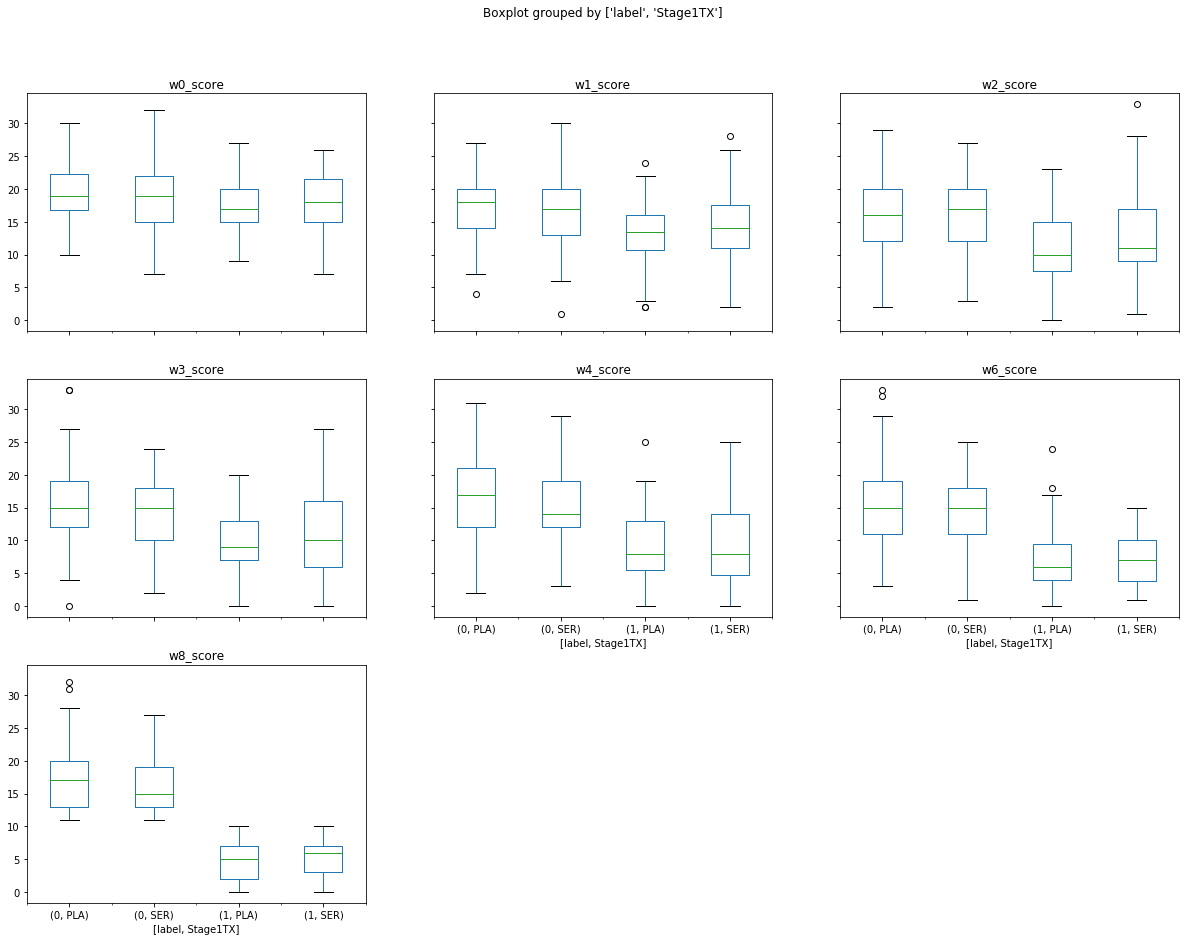

In [15]:
data.boxplot(column=first_trial_scores, by=['label', 'Stage1TX'], grid=False, figsize=(20,15))

Observing the distributions grouped by both treatment and outcome we see that there is a noticable difference between the outcome group distributions.  

One possible artifact of the missing values is that the outcome label is entirely determined by the w8_score.  However this field has 19% missing data.  All of these subjects would be labeled as negative, although their prior trends may reflect a positive outcome.  This can be observed in the many low valued Hamilton scores in the negative class even up to week 6.

### Mean and Variance of Scores

In [16]:
def plot_mean_variance_distribution(data):
    fig, ax = plt.subplots(3, sharex=True, sharey=True, figsize=(15,15))
    plt.figure(figsize=(25,20))

    errors = data[first_trial_scores].std()
    ax[0].errorbar(first_trial_scores, data[first_trial_scores].mean(), errors)
    ax[0].set_title('Population Mean and Variance of Scores')

    errors = data.loc[data['label'] == 1][first_trial_scores].std()
    ax[1].errorbar(first_trial_scores, data.loc[data['label'] == 1][first_trial_scores].mean(), errors)
    ax[1].set_title('Effective Treatment Mean and Variance of Scores')

    errors = data.loc[data['label'] == 0][first_trial_scores].std()
    ax[2].errorbar(first_trial_scores, data.loc[data['label'] == 0][first_trial_scores].mean(), errors)
    ax[2].set_title('Ineffective Treatment Mean and Variance of Scores')

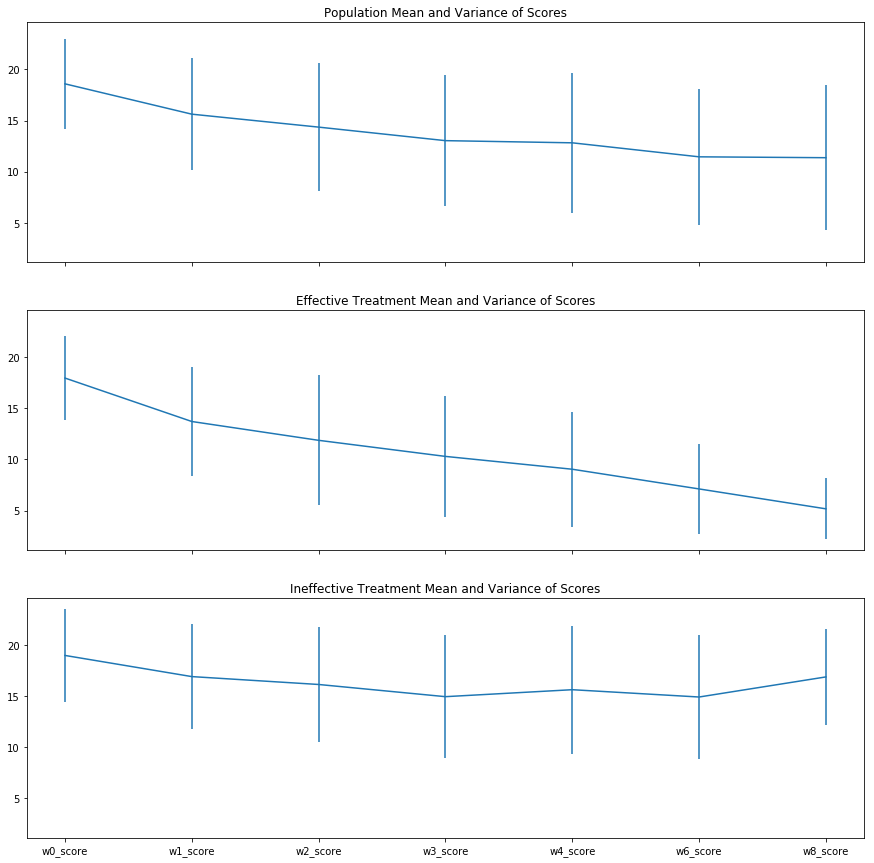

In [17]:
plot_mean_variance_distribution(data)

# Data Cleaning

We will consider rows which have at least 4 valid scores for the first trial period for cleaning.  Data points which have less than 4 valid scores will be discarded.

In [18]:
interpolated_data = data[data['w8_score'].notnull()].loc[data['valid_scores'] > 3].copy()

We will use pandas interpolate() function as a baseline imputation method.  Having done imputation we then recompute the labels for the rows.

In [19]:
interpolated_data[first_trial_scores] = interpolated_data[first_trial_scores].interpolate(axis=1)
interpolated_data['label'] = interpolated_data.apply(lambda row: 1 if row.w8_score <= 10 else 0, axis=1)

## Score Distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a16932750>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a16b06f50>]], dtype=object)

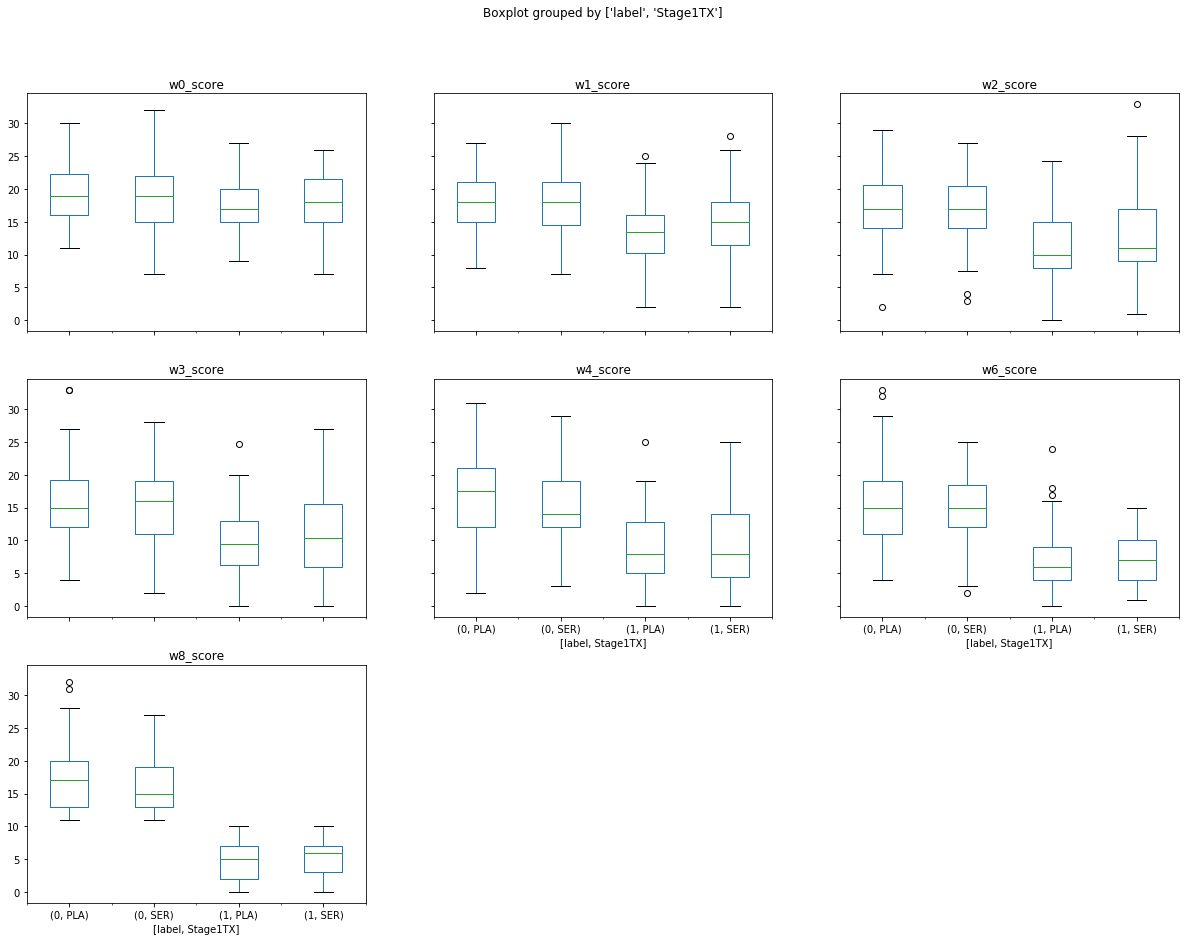

In [20]:
interpolated_data.boxplot(column=first_trial_scores, by=['label', 'Stage1TX'], grid=False, figsize=(20,15))

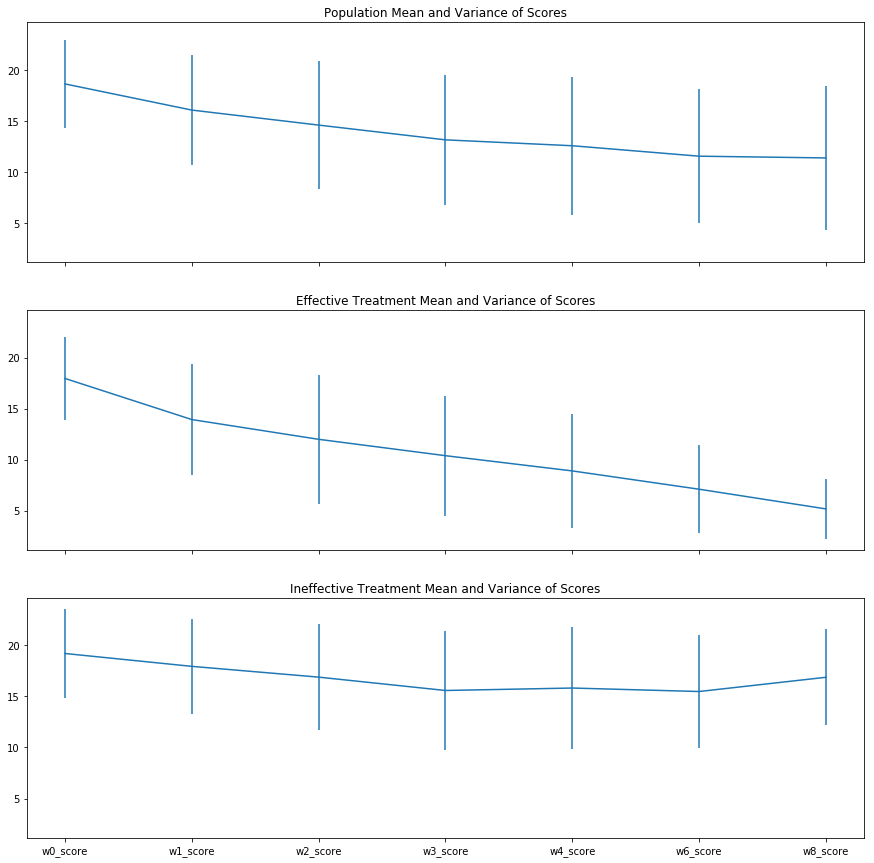

In [21]:
plot_mean_variance_distribution(interpolated_data)

We see that the box plots and mean/variance distributions have not changed significantly after imputation.  The box plots are slightly tighter in the quartiles with less pronounced outliers.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a173c45d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a176d9250>]], dtype=object)

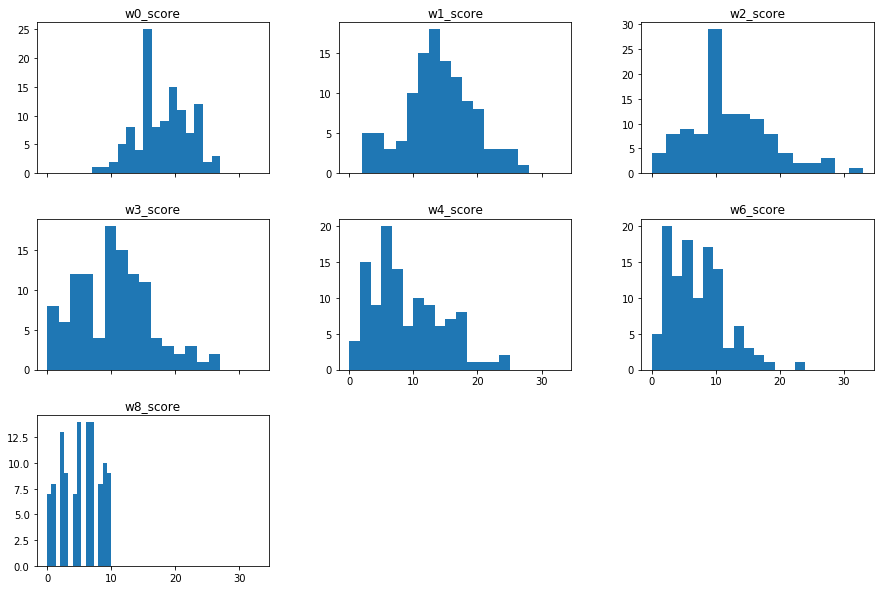

In [22]:
interpolated_data.loc[interpolated_data['label'] == 1].hist(column=first_trial_scores, grid=False, figsize=(15,10), bins=15, sharex=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a177795d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a17d99450>]], dtype=object)

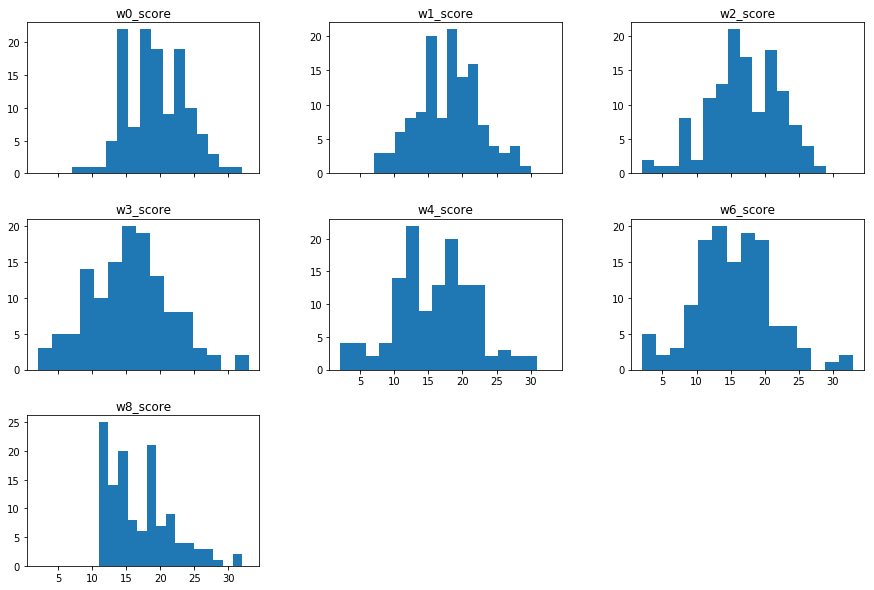

In [23]:
interpolated_data.loc[interpolated_data['label'] == 0].hist(column=first_trial_scores, grid=False, figsize=(15,10), sharex=True, bins=15)

The score histograms conditioned on the outcome label show noticably different distributions which become increasingly distinct as the weeks progress.

# Learning Algorithms

## Data Normalization

We will apply z-score normalization to the input data.

In [24]:
scaler = StandardScaler()
scaler.fit(interpolated_data[first_trial_scores[:-1]])
interpolated_data[first_trial_scores[:-1]] = scaler.transform(interpolated_data[first_trial_scores[:-1]])

First we will split our data into an 80/20 train/test split.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(interpolated_data[first_trial_scores[:-1]], interpolated_data['label'], test_size=0.2, random_state=12)

Next we will define an evaluation function which takes as input a learning algorithm and outputs the relevant statistics.  The function will return the accuracy which we will later use for visualization.

In [26]:
models = {}  # Holds accuracy scores for each learning algorithm

def evaluate_learner(model, X_train, X_test, y_train, y_test, fit=True):
    if fit:
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Output statistics
    print classification_report(y_test, y_pred, target_names=['Ineffective', 'Effective'])
    print('Accuracy: %f' % accuracy)
    
    return accuracy

## Logistic Regression

First we will try basic logistic regression.

In [27]:
models['Logistic_L2'] = evaluate_learner(LogisticRegression(penalty='l2'), X_train, X_test, y_train, y_test)

             precision    recall  f1-score   support

Ineffective       0.88      0.84      0.86        25
  Effective       0.83      0.87      0.85        23

avg / total       0.86      0.85      0.85        48

Accuracy: 0.854167


Next let's see how well L1 regularization works.

In [28]:
models['Logistic_L1'] = evaluate_learner(LogisticRegression(penalty='l1'), X_train, X_test, y_train, y_test)

             precision    recall  f1-score   support

Ineffective       0.91      0.84      0.87        25
  Effective       0.84      0.91      0.87        23

avg / total       0.88      0.88      0.87        48

Accuracy: 0.875000


### Hyperparameter Tuning

We will now tune logistic regression via the C hyperparameter.

#### L1 Regularization

In [29]:
# Previously searched: 
# [.001, .01, .1, 1, 10, 100]
logistic_CV = GridSearchCV(LogisticRegression(penalty='l1'), 
                           {'C': [.005, .01, .025, .05, .075, .09]}, 
                           cv=LeaveOneOut())
logistic_CV.fit(X_train, y_train)
print logistic_CV.best_estimator_

LogisticRegression(C=0.075, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [30]:
models['Logistic_L1_CV'] = evaluate_learner(logistic_CV, X_train, X_test, y_train, y_test, fit=False)

             precision    recall  f1-score   support

Ineffective       0.95      0.72      0.82        25
  Effective       0.76      0.96      0.85        23

avg / total       0.86      0.83      0.83        48

Accuracy: 0.833333


#### L2 Regularization

In [31]:
# Previously searched: 
# [.001, .01, .1, 1, 10, 100]
logistic_CV = GridSearchCV(LogisticRegression(penalty='l2'), 
                           {'C': [.001, .01, .1, 1, 10, 100]}, 
                           cv=LeaveOneOut())
logistic_CV.fit(X_train, y_train)
print logistic_CV.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [32]:
models['Logistic_L2_CV'] = evaluate_learner(logistic_CV, X_train, X_test, y_train, y_test, fit=False)

             precision    recall  f1-score   support

Ineffective       0.88      0.84      0.86        25
  Effective       0.83      0.87      0.85        23

avg / total       0.86      0.85      0.85        48

Accuracy: 0.854167


## SVM

We will try various kernel SVM learners using RBF, linear, and polynomial kernels.

In [33]:
models['SVM_RBF'] = evaluate_learner(svm.SVC(), X_train, X_test, y_train, y_test)

             precision    recall  f1-score   support

Ineffective       0.83      0.80      0.82        25
  Effective       0.79      0.83      0.81        23

avg / total       0.81      0.81      0.81        48

Accuracy: 0.812500


In [34]:
models['SVM_Linear'] = evaluate_learner(svm.SVC(kernel="linear"), X_train, X_test, y_train, y_test)

             precision    recall  f1-score   support

Ineffective       0.91      0.80      0.85        25
  Effective       0.81      0.91      0.86        23

avg / total       0.86      0.85      0.85        48

Accuracy: 0.854167


In [35]:
models['SVM_Poly'] = evaluate_learner(svm.SVC(kernel="poly", degree=3), X_train, X_test, y_train, y_test)

             precision    recall  f1-score   support

Ineffective       0.71      0.88      0.79        25
  Effective       0.82      0.61      0.70        23

avg / total       0.76      0.75      0.74        48

Accuracy: 0.750000


### Hyperparameter Tuning

In [36]:
# Previously searched: 
# [.001, .01, .1, 1, 10, 100]
SVM_CV = GridSearchCV(svm.SVC(), 
                      {'C': [.001, .01, .1, 1, 10, 100]}, 
                      cv=LeaveOneOut())
SVM_CV.fit(X_train, y_train)
print SVM_CV.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [37]:
models['SVM_RBF_CV'] = evaluate_learner(SVM_CV, X_train, X_test, y_train, y_test, fit=False)

             precision    recall  f1-score   support

Ineffective       0.83      0.80      0.82        25
  Effective       0.79      0.83      0.81        23

avg / total       0.81      0.81      0.81        48

Accuracy: 0.812500


In [38]:
SVM_CV = GridSearchCV(svm.SVC(kernel="linear"), 
                      {'C': [.001, .01, .1, 1, 10, 100]}, 
                      cv=LeaveOneOut())
SVM_CV.fit(X_train, y_train)
print SVM_CV.best_estimator_

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [39]:
models['SVM_Linear_CV'] = evaluate_learner(SVM_CV, X_train, X_test, y_train, y_test, fit=False)

             precision    recall  f1-score   support

Ineffective       0.88      0.84      0.86        25
  Effective       0.83      0.87      0.85        23

avg / total       0.86      0.85      0.85        48

Accuracy: 0.854167


In [40]:
SVM_CV = GridSearchCV(svm.SVC(kernel="poly"),
                      {'C': [.001, .01, .1, 1, 10, 100], 'degree': [1, 2, 3, 4]}, 
                      cv=LeaveOneOut())
SVM_CV.fit(X_train, y_train)
print SVM_CV.best_estimator_

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [41]:
models['SVM_Poly_CV'] = evaluate_learner(SVM_CV, X_train, X_test, y_train, y_test, fit=False)

             precision    recall  f1-score   support

Ineffective       0.87      0.80      0.83        25
  Effective       0.80      0.87      0.83        23

avg / total       0.84      0.83      0.83        48

Accuracy: 0.833333


We can see that our models are liable to overfit the training data.  This can be seen by noticing the decrease in test score for L1 Logistic Regression compared to the untuned baseline.

## Model Accuracy Comparison

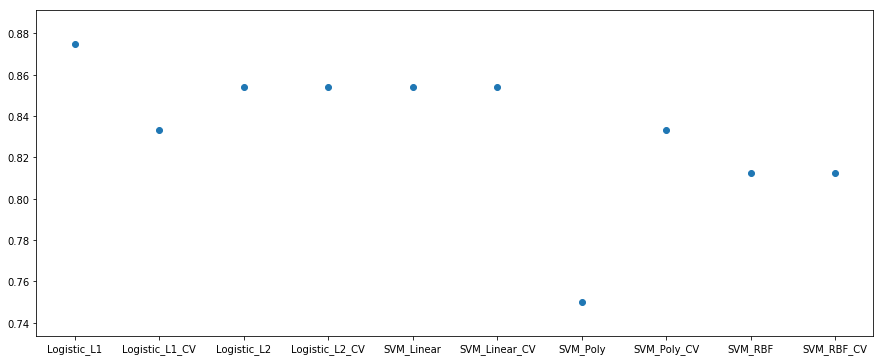

In [42]:
x, y = zip(*sorted(models.items())) # unpack a list of pairs into two tuples

plt.figure(figsize=(15,6))
plt.scatter(x, y)
plt.show()

# Labeling via Stage1TX vs Stage2TX Values

We will try labeling the data via the change in Stage1TX and Stage2TX values.  If the values are the same, then the treatment was effective.

First we will remove all data points which do not have a w8_score value (which implies there is no Stage2TX value as well).

In [43]:
# Remove bad data
stage_labeled_data = data[data['w8_score'].notnull()].loc[data['valid_scores'] > 3].copy()

# Relabel data
stage_labeled_data['label'] = stage_labeled_data.apply(lambda row: 1 if row.Stage1TX == row.Stage2TX and row.w8_score <= 10 else 0, axis=1)

# Impute missing values
stage_labeled_data[first_trial_scores] = stage_labeled_data[first_trial_scores].interpolate(axis=1)

We should check how many labels changed between the old labeling criteria and the new one.

In [44]:
print 'Change in TX Labels:'
stage_labeled_data['label'].value_counts()

Change in TX Labels:


0    145
1     95
Name: label, dtype: int64

In [45]:
print 'Thresholded Data Labels:'
interpolated_data['label'].value_counts()

Thresholded Data Labels:


0    127
1    113
Name: label, dtype: int64

We see that 6 samples have switched from positive to negative, approximately 5% of the original positive labels.

## Data Distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a181987d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a18344ad0>]], dtype=object)

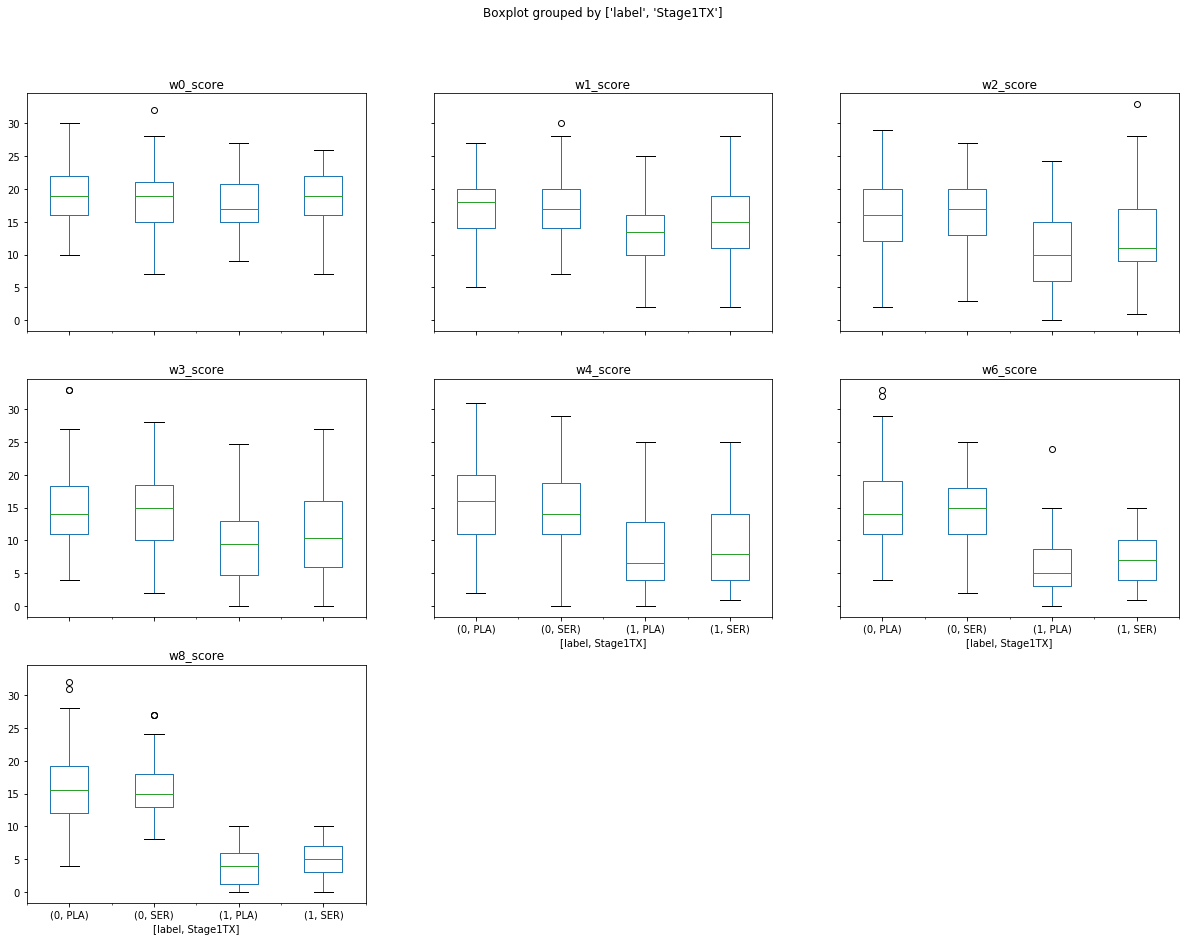

In [46]:
stage_labeled_data.boxplot(column=first_trial_scores, by=['label', 'Stage1TX'], grid=False, figsize=(20,15))

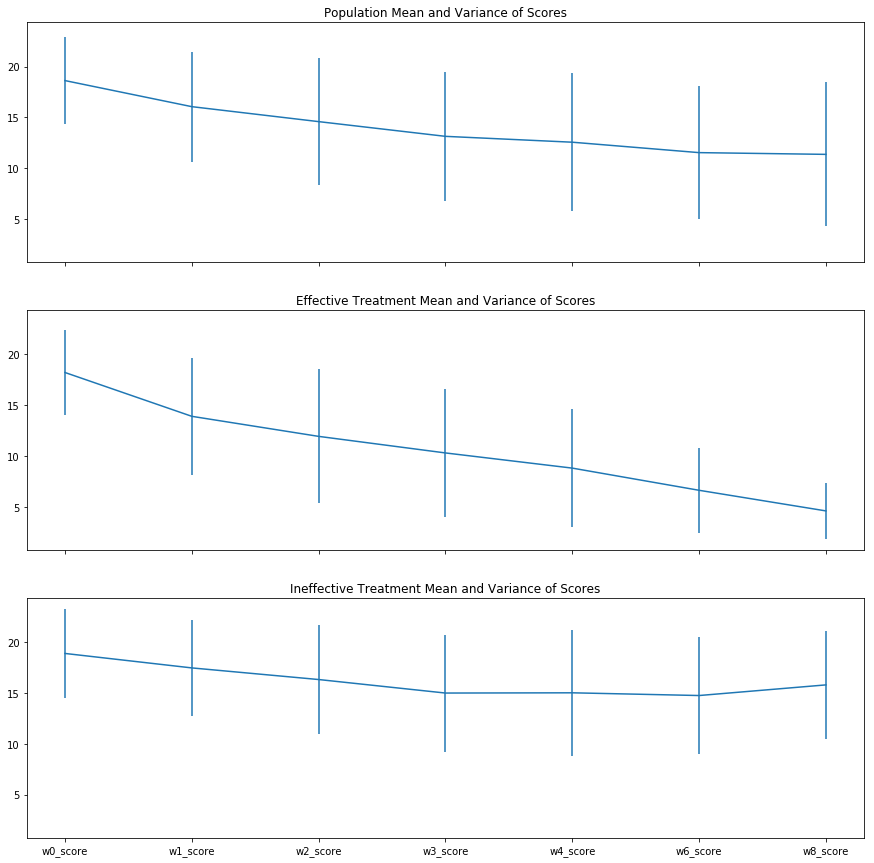

In [47]:
plot_mean_variance_distribution(stage_labeled_data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a18d1d790>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a19450910>]], dtype=object)

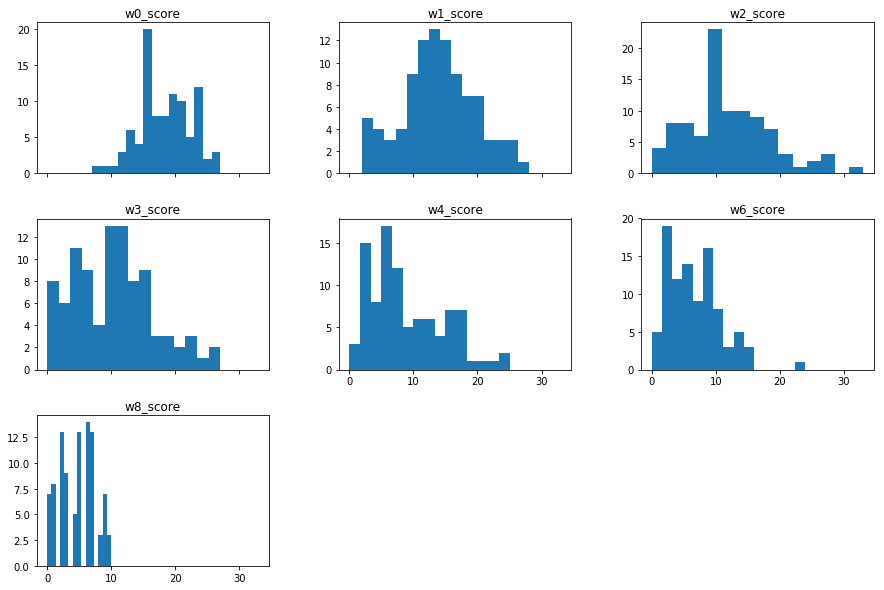

In [48]:
stage_labeled_data.loc[stage_labeled_data['label'] == 1].hist(column=first_trial_scores, grid=False, figsize=(15,10), bins=15, sharex=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a18ccdc50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a198fa050>]], dtype=object)

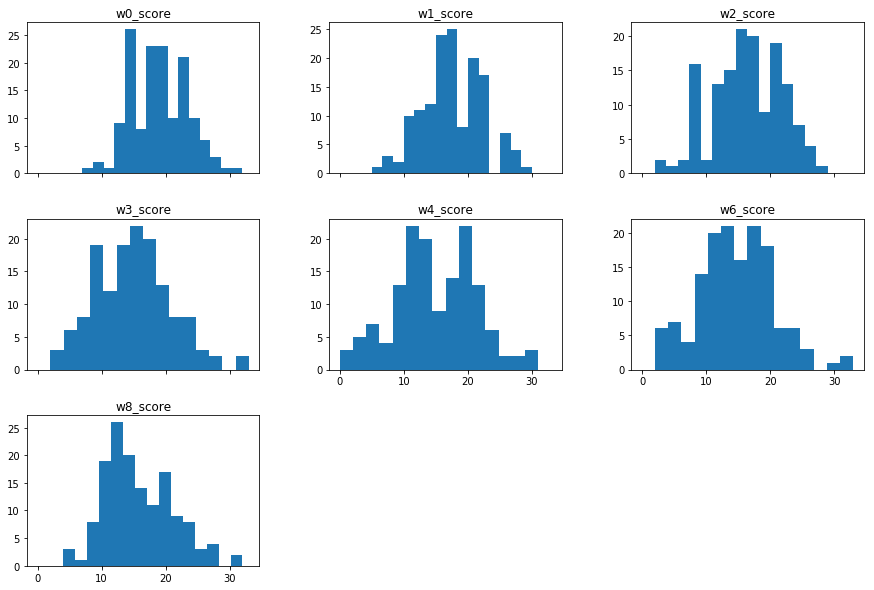

In [49]:
stage_labeled_data.loc[stage_labeled_data['label'] == 0].hist(column=first_trial_scores, grid=False, figsize=(15,10), bins=15, sharex=True)

## Learning Algorithms

First we will perform z-score normalization and 80/20 train/test split again.

In [50]:
stage_labeled_models = {}  # Holds accuracy scores

# z-score normalization
scaler = StandardScaler()
scaler.fit(stage_labeled_data[first_trial_scores[:-1]])
stage_labeled_data[first_trial_scores[:-1]] = scaler.transform(stage_labeled_data[first_trial_scores[:-1]])

# Train/test split
stage_labeled_X_train, stage_labeled_X_test, stage_labeled_y_train, stage_labeled_y_test = train_test_split(stage_labeled_data[first_trial_scores[:-1]], stage_labeled_data['label'], test_size=0.2, random_state=12)

In [51]:
stage_labeled_models['Logistic_L2'] = evaluate_learner(LogisticRegression(penalty='l2'), stage_labeled_X_train, stage_labeled_X_test, stage_labeled_y_train, stage_labeled_y_test)

             precision    recall  f1-score   support

Ineffective       0.85      0.85      0.85        27
  Effective       0.81      0.81      0.81        21

avg / total       0.83      0.83      0.83        48

Accuracy: 0.833333


In [52]:
stage_labeled_models['Logistic_L1'] = evaluate_learner(LogisticRegression(penalty='l1'), stage_labeled_X_train, stage_labeled_X_test, stage_labeled_y_train, stage_labeled_y_test)

             precision    recall  f1-score   support

Ineffective       0.85      0.85      0.85        27
  Effective       0.81      0.81      0.81        21

avg / total       0.83      0.83      0.83        48

Accuracy: 0.833333


In [53]:
stage_labeled_models['SVM_RBF'] = evaluate_learner(svm.SVC(), stage_labeled_X_train, stage_labeled_X_test, stage_labeled_y_train, stage_labeled_y_test)

             precision    recall  f1-score   support

Ineffective       0.84      0.78      0.81        27
  Effective       0.74      0.81      0.77        21

avg / total       0.80      0.79      0.79        48

Accuracy: 0.791667


In [54]:
stage_labeled_models['SVM_Linear'] = evaluate_learner(svm.SVC(kernel='linear'), stage_labeled_X_train, stage_labeled_X_test, stage_labeled_y_train, stage_labeled_y_test)

             precision    recall  f1-score   support

Ineffective       0.88      0.85      0.87        27
  Effective       0.82      0.86      0.84        21

avg / total       0.86      0.85      0.85        48

Accuracy: 0.854167


In [55]:
stage_labeled_models['SVM_Poly'] = evaluate_learner(svm.SVC(kernel='poly'), stage_labeled_X_train, stage_labeled_X_test, stage_labeled_y_train, stage_labeled_y_test)

             precision    recall  f1-score   support

Ineffective       0.69      0.89      0.77        27
  Effective       0.77      0.48      0.59        21

avg / total       0.72      0.71      0.69        48

Accuracy: 0.708333


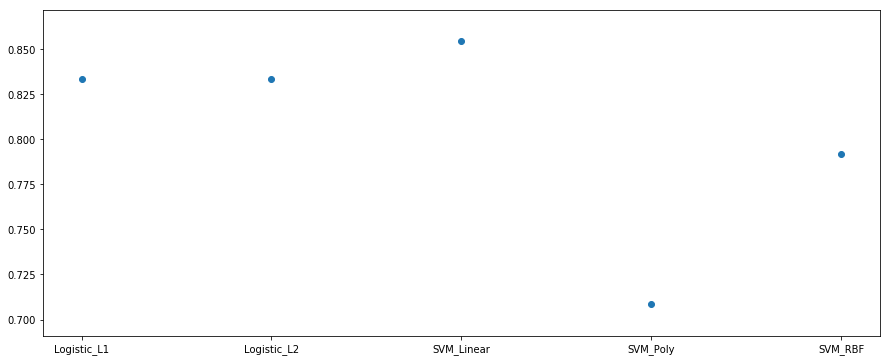

In [56]:
x, y = zip(*sorted(stage_labeled_models.items())) # unpack a list of pairs into two tuples

plt.figure(figsize=(15,6))
plt.scatter(x, y)
plt.show()